In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
 #   for filename in filenames:
  #      print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Download TorchVision repo to use some files from
# references/detection
!pip install pycocotools --quiet
!git clone https://github.com/pytorch/vision.git
!git checkout v0.3.0

!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

Cloning into 'vision'...
remote: Enumerating objects: 531472, done.
remote: Counting objects: 100% (45082/45082), done.
remote: Compressing objects: 100% (2074/2074), done.
remote: Total 531472 (delta 43039), reused 44915 (delta 42935), pack-reused 486390
Receiving objects: 100% (531472/531472), 1.00 GiB | 40.59 MiB/s, done.
Resolving deltas: 100% (496283/496283), done.
fatal: not a git repository (or any parent up to mount point /kaggle)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


In [3]:
# Basic python and ML Libraries
import os
import random
import numpy as np
import pandas as pd
# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# We will be reading images using OpenCV
import cv2

# xml library for parsing xml files
from xml.etree import ElementTree as et

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchvision libraries
import torch
from torch.utils.data import Subset
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# these are the helper libraries imported.
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# for image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2


In [4]:
mkdir -p /kaggle/working/train-inriaperson && cp -r /kaggle/input/inriaperson/Train/Annotations/* /kaggle/working/train-inriaperson

In [5]:
cp -r /kaggle/input/inriaperson/Train/JPEGImages/* /kaggle/working/train-inriaperson

In [6]:
# defining the files directory and testing directory
train_dir = '/kaggle/working/train-inriaperson'
test_dir = '/kaggle/input/citypersons-testselection/NewTest'

In [7]:
class ImagesDataset(torch.utils.data.Dataset):

    def __init__(self, files_dir, width, height, transforms=None):
        self.transforms = transforms
        self.files_dir = files_dir
        self.height = height
        self.width = width
            
        self.imgs = [image for image in sorted(os.listdir(files_dir)) if image.endswith(('.png', '.jpg'))]
        
        
        # classes: 0 index is reserved for background
        self.classes = ['background','pedestrian']

    def __getitem__(self, idx):

        img_name = self.imgs[idx]
        image_path = os.path.join(self.files_dir, img_name)

        # reading the images and converting them to correct size and color    
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        # diving by 255
        img_res /= 255.0
        
        # annotation file
        annot_filename = img_name[:-4] + '.xml'
        annot_file_path = os.path.join(self.files_dir, annot_filename)
        
        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()
        
        # cv2 image gives size as height x width
        wt = img.shape[1]
        ht = img.shape[0]
        
        # box coordinates for xml files are extracted and corrected for image size given
        for member in root.findall('object'):
            label_text = member.find('name').text.lower()
            if label_text in ['ped', 'pedestrian','person']:
                labels.append(self.classes.index('pedestrian')) 
            
            # bounding box
            xmin = int(member.find('bndbox').find('xmin').text)
            xmax = int(member.find('bndbox').find('xmax').text)
            
            ymin = int(member.find('bndbox').find('ymin').text)
            ymax = int(member.find('bndbox').find('ymax').text)
            
            
            xmin_corr = (xmin/wt)*self.width
            xmax_corr = (xmax/wt)*self.width
            ymin_corr = (ymin/ht)*self.height
            ymax_corr = (ymax/ht)*self.height
            
            boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
        
        # convert boxes into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        # getting the areas of the boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # suppose all instances are not crowd
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        
        labels = torch.as_tensor(labels, dtype=torch.int64)


        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        # image_id
        image_id = idx
        target["image_id"] = image_id
        
  


        if self.transforms:
            
            sample = self.transforms(image = img_res,
                                     bboxes = target['boxes'],
                                     labels = labels)
            
            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
            
            
        return img_res, target

    def __len__(self):
        return len(self.imgs)

In [8]:
# check train dataset
train_dataset = ImagesDataset(train_dir, 1920, 1080)
print('length of dataset = ', len(train_dataset), '\n')

# getting the image and target for a test index.  Feel free to change the index.
img, target = train_dataset[78]
print(img.shape, '\n',target)

length of dataset =  614 

(1080, 1920, 3) 
 {'boxes': tensor([[ 584.3478,  273.3197, 1241.0435,  631.8442]]), 'labels': tensor([1]), 'area': tensor([235441.5156]), 'iscrowd': tensor([0]), 'image_id': 78}


In [9]:
#train_dataset.classes

In [10]:
#Adjust the size of train dataset to be align with other training datasets

# Define the total number of samples in your dataset
total_samples = len(train_dataset)

# Define the percentage of the dataset you want to load
portion_to_load = 0.5  # Example: load 50% of the dataset

# Calculate the number of samples to load
num_samples_to_load = int(total_samples * portion_to_load)

# Generate random indices to select a random subset of the dataset
indices = random.sample(range(total_samples), num_samples_to_load)

# Create a Subset dataset containing only the selected indices
subset_train_dataset = Subset(train_dataset, indices)
len(subset_train_dataset)

307

In [11]:
# check test dataset
test_dataset = ImagesDataset(test_dir, 224, 224)
print('length of dataset = ', len(test_dataset), '\n')

# getting the image and target for a test index.  Feel free to change the index.
img, target = test_dataset[7]
print(img.shape, '\n',target)

length of dataset =  75 

(224, 224, 3) 
 {'boxes': tensor([[ 29.7500,  84.0000,  34.1250, 105.0000],
        [ 32.9000,  83.6500,  37.2750, 105.3500],
        [ 80.5000,  86.8000,  81.5500,  92.7500],
        [ 85.2250,  87.8500,  86.4500,  93.4500],
        [ 86.6250,  88.2000,  87.5000,  93.4500],
        [ 87.5000,  88.5500,  88.3750,  93.8000],
        [ 92.4000,  88.2000,  93.2750,  93.1000],
        [ 93.2750,  88.2000,  94.1500,  93.4500],
        [104.6500,  88.2000, 106.0500,  94.8500],
        [112.3500,  80.8500, 119.7000, 117.2500],
        [129.5000,  85.7500, 132.6500, 100.4500],
        [131.9500,  82.6000, 135.6250, 100.4500],
        [137.0250,  83.6500, 139.6500,  96.9500],
        [205.4500,  76.6500, 212.4500, 110.9500],
        [ 62.1250,  87.8500,  64.4000,  99.4000],
        [ 60.2000,  88.2000,  62.3000,  99.4000],
        [ 49.1750,  86.4500,  52.3250, 101.8500],
        [ 47.0750,  87.1500,  50.0500, 101.8500],
        [ 44.1000,  86.4500,  47.2500, 101.8500]

In [12]:
# Function to visualize bounding boxes in the image

def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()
    


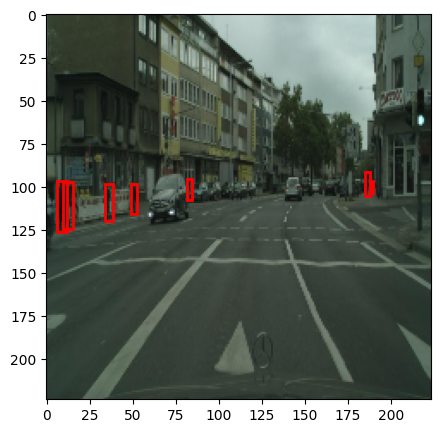

In [13]:
# plotting the image with bboxes. Feel free to change the index
img, target = test_dataset[2]
plot_img_bbox(img, target)

In [14]:

def get_object_detection_model(num_classes):

    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

    return model

In [15]:
# Send train=True fro training transforms and False for val/test transforms
def get_transform(train):
    
    if train:
        return A.Compose([
            A.HorizontalFlip(0.5),
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),
            A.Rotate(limit=15, p=0.5),
            ToTensorV2(p=1.0)
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [16]:
# use our dataset and defined transformations
train_dataset = ImagesDataset(train_dir, 1920, 1080, transforms= get_transform(train=True))
subset_train_dataset = Subset(train_dataset, indices)
train_dataset = subset_train_dataset
dataset_test = ImagesDataset(test_dir, 1920, 1080, transforms= get_transform(train=False))

# define training and validation data loaders
data_loader_train = torch.utils.data.DataLoader(
    train_dataset, batch_size=4, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=4, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [17]:
# to train on gpu if selected.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


num_classes = 2

# get the model using our helper function
model = get_object_detection_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 160MB/s]


In [18]:
# training for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: [0]  [ 0/77]  eta: 0:05:08  lr: 0.000071  loss: 0.8850 (0.8850)  loss_classifier: 0.5307 (0.5307)  loss_box_reg: 0.2833 (0.2833)  loss_objectness: 0.0636 (0.0636)  loss_rpn_box_reg: 0.0074 (0.0074)  time: 4.0004  data: 0.9820  max mem: 4799


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: [0]  [10/77]  eta: 0:01:04  lr: 0.000728  loss: 0.6533 (0.6691)  loss_classifier: 0.3995 (0.3861)  loss_box_reg: 0.2833 (0.2523)  loss_objectness: 0.0241 (0.0267)  loss_rpn_box_reg: 0.0031 (0.0040)  time: 0.9560  data: 0.1203  max mem: 4957


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: [0]  [20/77]  eta: 0:00:45  lr: 0.001385  loss: 0.5000 (0.5747)  loss_classifier: 0.2081 (0.3013)  loss_box_reg: 0.2338 (0.2477)  loss_objectness: 0.0187 (0.0217)  loss_rpn_box_reg: 0.0034 (0.0040)  time: 0.6470  data: 0.0333  max mem: 4958


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: [0]  [30/77]  eta: 0:00:35  lr: 0.002042  loss: 0.4252 (0.5057)  loss_classifier: 0.1707 (0.2433)  loss_box_reg: 0.2338 (0.2411)  loss_objectness: 0.0090 (0.0176)  loss_rpn_box_reg: 0.0033 (0.0037)  time: 0.6454  data: 0.0332  max mem: 4958


libpng warning: iCCP: known incorrect sRGB profile


Epoch: [0]  [40/77]  eta: 0:00:26  lr: 0.002700  loss: 0.2690 (0.4497)  loss_classifier: 0.0805 (0.2015)  loss_box_reg: 0.1821 (0.2302)  loss_objectness: 0.0048 (0.0144)  loss_rpn_box_reg: 0.0028 (0.0036)  time: 0.6468  data: 0.0339  max mem: 4958


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: [0]  [50/77]  eta: 0:00:19  lr: 0.003357  loss: 0.2803 (0.4207)  loss_classifier: 0.0767 (0.1822)  loss_box_reg: 0.1821 (0.2203)  loss_objectness: 0.0041 (0.0141)  loss_rpn_box_reg: 0.0037 (0.0041)  time: 0.6454  data: 0.0326  max mem: 4958


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: [0]  [60/77]  eta: 0:00:11  lr: 0.004014  loss: 0.2341 (0.3862)  loss_classifier: 0.0795 (0.1643)  loss_box_reg: 0.1396 (0.2045)  loss_objectness: 0.0069 (0.0133)  loss_rpn_box_reg: 0.0032 (0.0041)  time: 0.6432  data: 0.0310  max mem: 4958


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: [0]  [70/77]  eta: 0:00:04  lr: 0.004671  loss: 0.1903 (0.3579)  loss_classifier: 0.0620 (0.1504)  loss_box_reg: 0.1123 (0.1910)  loss_objectness: 0.0068 (0.0125)  loss_rpn_box_reg: 0.0031 (0.0040)  time: 0.6448  data: 0.0318  max mem: 4958
Epoch: [0]  [76/77]  eta: 0:00:00  lr: 0.005000  loss: 0.1645 (0.3430)  loss_classifier: 0.0590 (0.1426)  loss_box_reg: 0.0919 (0.1846)  loss_objectness: 0.0032 (0.0117)  loss_rpn_box_reg: 0.0033 (0.0041)  time: 0.6372  data: 0.0308  max mem: 4958
Epoch: [0] Total time: 0:00:52 (0.6879 s / it)
creating index...
index created!
Test:  [ 0/19]  eta: 0:00:18  model_time: 0.3085 (0.3085)  evaluator_time: 0.0108 (0.0108)  time: 0.9691  data: 0.5745  max mem: 4958
Test:  [18/19]  eta: 0:00:00  model_time: 0.2549 (0.2553)  evaluator_time: 0.0084 (0.0141)  time: 0.3608  data: 0.0596  max mem: 4958
Test: Total time: 0:00:06 (0.3626 s / it)
Averaged stats: model_time: 0.2549 (0.2553)  evaluator_time: 0.0084 (0.0141)
Accumulating evaluation results...
DO

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: [1]  [ 0/77]  eta: 0:02:15  lr: 0.005000  loss: 0.1243 (0.1243)  loss_classifier: 0.0348 (0.0348)  loss_box_reg: 0.0846 (0.0846)  loss_objectness: 0.0020 (0.0020)  loss_rpn_box_reg: 0.0028 (0.0028)  time: 1.7602  data: 1.0636  max mem: 4958


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: [1]  [10/77]  eta: 0:00:51  lr: 0.005000  loss: 0.1551 (0.1571)  loss_classifier: 0.0582 (0.0543)  loss_box_reg: 0.0937 (0.0980)  loss_objectness: 0.0018 (0.0016)  loss_rpn_box_reg: 0.0028 (0.0031)  time: 0.7631  data: 0.1304  max mem: 4958


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: [1]  [20/77]  eta: 0:00:40  lr: 0.005000  loss: 0.1720 (0.1814)  loss_classifier: 0.0591 (0.0666)  loss_box_reg: 0.1029 (0.1079)  loss_objectness: 0.0018 (0.0037)  loss_rpn_box_reg: 0.0028 (0.0032)  time: 0.6597  data: 0.0365  max mem: 4959


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: [1]  [30/77]  eta: 0:00:32  lr: 0.005000  loss: 0.1660 (0.1818)  loss_classifier: 0.0596 (0.0670)  loss_box_reg: 0.1029 (0.1079)  loss_objectness: 0.0026 (0.0036)  loss_rpn_box_reg: 0.0037 (0.0033)  time: 0.6571  data: 0.0354  max mem: 4959


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: [1]  [40/77]  eta: 0:00:25  lr: 0.005000  loss: 0.1620 (0.1790)  loss_classifier: 0.0613 (0.0654)  loss_box_reg: 0.0952 (0.1067)  loss_objectness: 0.0026 (0.0037)  loss_rpn_box_reg: 0.0033 (0.0032)  time: 0.6517  data: 0.0337  max mem: 4959


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: [1]  [50/77]  eta: 0:00:18  lr: 0.005000  loss: 0.1593 (0.1754)  loss_classifier: 0.0607 (0.0637)  loss_box_reg: 0.0952 (0.1048)  loss_objectness: 0.0034 (0.0037)  loss_rpn_box_reg: 0.0032 (0.0033)  time: 0.6504  data: 0.0338  max mem: 4959


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: [1]  [60/77]  eta: 0:00:11  lr: 0.005000  loss: 0.1380 (0.1698)  loss_classifier: 0.0544 (0.0618)  loss_box_reg: 0.0875 (0.1015)  loss_objectness: 0.0011 (0.0033)  loss_rpn_box_reg: 0.0029 (0.0032)  time: 0.6531  data: 0.0350  max mem: 4959


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: [1]  [70/77]  eta: 0:00:04  lr: 0.005000  loss: 0.1403 (0.1744)  loss_classifier: 0.0544 (0.0638)  loss_box_reg: 0.0875 (0.1037)  loss_objectness: 0.0013 (0.0036)  loss_rpn_box_reg: 0.0028 (0.0033)  time: 0.6527  data: 0.0344  max mem: 4959
Epoch: [1]  [76/77]  eta: 0:00:00  lr: 0.005000  loss: 0.1339 (0.1715)  loss_classifier: 0.0529 (0.0630)  loss_box_reg: 0.0826 (0.1016)  loss_objectness: 0.0018 (0.0036)  loss_rpn_box_reg: 0.0028 (0.0033)  time: 0.6426  data: 0.0325  max mem: 4959
Epoch: [1] Total time: 0:00:51 (0.6669 s / it)
creating index...
index created!
Test:  [ 0/19]  eta: 0:00:18  model_time: 0.2805 (0.2805)  evaluator_time: 0.0069 (0.0069)  time: 0.9509  data: 0.6072  max mem: 4959
Test:  [18/19]  eta: 0:00:00  model_time: 0.2546 (0.2537)  evaluator_time: 0.0069 (0.0109)  time: 0.3559  data: 0.0605  max mem: 4959
Test: Total time: 0:00:06 (0.3579 s / it)
Averaged stats: model_time: 0.2546 (0.2537)  evaluator_time: 0.0069 (0.0109)
Accumulating evaluation results...
DO

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: [2]  [ 0/77]  eta: 0:02:40  lr: 0.005000  loss: 0.1193 (0.1193)  loss_classifier: 0.0504 (0.0504)  loss_box_reg: 0.0642 (0.0642)  loss_objectness: 0.0024 (0.0024)  loss_rpn_box_reg: 0.0023 (0.0023)  time: 2.0818  data: 1.4141  max mem: 4959


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: [2]  [10/77]  eta: 0:00:53  lr: 0.005000  loss: 0.1526 (0.1580)  loss_classifier: 0.0597 (0.0599)  loss_box_reg: 0.0860 (0.0926)  loss_objectness: 0.0014 (0.0024)  loss_rpn_box_reg: 0.0032 (0.0031)  time: 0.7966  data: 0.1627  max mem: 4959


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: [2]  [20/77]  eta: 0:00:41  lr: 0.005000  loss: 0.1435 (0.1593)  loss_classifier: 0.0493 (0.0594)  loss_box_reg: 0.0811 (0.0943)  loss_objectness: 0.0014 (0.0029)  loss_rpn_box_reg: 0.0028 (0.0028)  time: 0.6605  data: 0.0361  max mem: 4959


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: [2]  [30/77]  eta: 0:00:33  lr: 0.005000  loss: 0.1347 (0.1585)  loss_classifier: 0.0500 (0.0576)  loss_box_reg: 0.0811 (0.0946)  loss_objectness: 0.0014 (0.0030)  loss_rpn_box_reg: 0.0025 (0.0032)  time: 0.6518  data: 0.0340  max mem: 4959


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: [2]  [40/77]  eta: 0:00:25  lr: 0.005000  loss: 0.1389 (0.1616)  loss_classifier: 0.0502 (0.0584)  loss_box_reg: 0.0922 (0.0976)  loss_objectness: 0.0004 (0.0025)  loss_rpn_box_reg: 0.0028 (0.0032)  time: 0.6556  data: 0.0345  max mem: 4959


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: [2]  [50/77]  eta: 0:00:18  lr: 0.005000  loss: 0.1463 (0.1597)  loss_classifier: 0.0488 (0.0573)  loss_box_reg: 0.0910 (0.0970)  loss_objectness: 0.0006 (0.0023)  loss_rpn_box_reg: 0.0028 (0.0031)  time: 0.6573  data: 0.0350  max mem: 4959


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: [2]  [60/77]  eta: 0:00:11  lr: 0.005000  loss: 0.1475 (0.1602)  loss_classifier: 0.0488 (0.0569)  loss_box_reg: 0.0910 (0.0979)  loss_objectness: 0.0012 (0.0023)  loss_rpn_box_reg: 0.0029 (0.0032)  time: 0.6525  data: 0.0339  max mem: 4959


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: [2]  [70/77]  eta: 0:00:04  lr: 0.005000  loss: 0.1633 (0.1643)  loss_classifier: 0.0586 (0.0585)  loss_box_reg: 0.1003 (0.1004)  loss_objectness: 0.0013 (0.0022)  loss_rpn_box_reg: 0.0031 (0.0032)  time: 0.6483  data: 0.0325  max mem: 4959
Epoch: [2]  [76/77]  eta: 0:00:00  lr: 0.005000  loss: 0.1475 (0.1621)  loss_classifier: 0.0556 (0.0575)  loss_box_reg: 0.0917 (0.0993)  loss_objectness: 0.0013 (0.0022)  loss_rpn_box_reg: 0.0022 (0.0031)  time: 0.6397  data: 0.0319  max mem: 4959
Epoch: [2] Total time: 0:00:51 (0.6709 s / it)
creating index...
index created!
Test:  [ 0/19]  eta: 0:00:18  model_time: 0.2825 (0.2825)  evaluator_time: 0.0065 (0.0065)  time: 0.9822  data: 0.6356  max mem: 4959
Test:  [18/19]  eta: 0:00:00  model_time: 0.2562 (0.2556)  evaluator_time: 0.0050 (0.0108)  time: 0.3626  data: 0.0650  max mem: 4959
Test: Total time: 0:00:06 (0.3645 s / it)
Averaged stats: model_time: 0.2562 (0.2556)  evaluator_time: 0.0050 (0.0108)
Accumulating evaluation results...
DO

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: [3]  [ 0/77]  eta: 0:02:16  lr: 0.000500  loss: 0.2049 (0.2049)  loss_classifier: 0.0773 (0.0773)  loss_box_reg: 0.1214 (0.1214)  loss_objectness: 0.0023 (0.0023)  loss_rpn_box_reg: 0.0039 (0.0039)  time: 1.7764  data: 1.0753  max mem: 4959


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: [3]  [10/77]  eta: 0:00:51  lr: 0.000500  loss: 0.1671 (0.1534)  loss_classifier: 0.0576 (0.0543)  loss_box_reg: 0.1012 (0.0952)  loss_objectness: 0.0007 (0.0008)  loss_rpn_box_reg: 0.0034 (0.0030)  time: 0.7682  data: 0.1318  max mem: 4959


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: [3]  [20/77]  eta: 0:00:40  lr: 0.000500  loss: 0.1164 (0.1364)  loss_classifier: 0.0470 (0.0503)  loss_box_reg: 0.0843 (0.0823)  loss_objectness: 0.0008 (0.0011)  loss_rpn_box_reg: 0.0022 (0.0026)  time: 0.6569  data: 0.0350  max mem: 4959


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: [3]  [30/77]  eta: 0:00:32  lr: 0.000500  loss: 0.1105 (0.1393)  loss_classifier: 0.0470 (0.0517)  loss_box_reg: 0.0707 (0.0838)  loss_objectness: 0.0008 (0.0011)  loss_rpn_box_reg: 0.0022 (0.0026)  time: 0.6477  data: 0.0322  max mem: 4959


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: [3]  [40/77]  eta: 0:00:25  lr: 0.000500  loss: 0.1220 (0.1354)  loss_classifier: 0.0423 (0.0493)  loss_box_reg: 0.0761 (0.0822)  loss_objectness: 0.0005 (0.0013)  loss_rpn_box_reg: 0.0023 (0.0026)  time: 0.6538  data: 0.0334  max mem: 4959


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: [3]  [50/77]  eta: 0:00:18  lr: 0.000500  loss: 0.1220 (0.1361)  loss_classifier: 0.0401 (0.0496)  loss_box_reg: 0.0761 (0.0825)  loss_objectness: 0.0014 (0.0014)  loss_rpn_box_reg: 0.0025 (0.0026)  time: 0.6564  data: 0.0350  max mem: 4959


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: [3]  [60/77]  eta: 0:00:11  lr: 0.000500  loss: 0.1284 (0.1345)  loss_classifier: 0.0425 (0.0486)  loss_box_reg: 0.0747 (0.0819)  loss_objectness: 0.0009 (0.0015)  loss_rpn_box_reg: 0.0022 (0.0025)  time: 0.6562  data: 0.0352  max mem: 4959


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: [3]  [70/77]  eta: 0:00:04  lr: 0.000500  loss: 0.1199 (0.1332)  loss_classifier: 0.0446 (0.0491)  loss_box_reg: 0.0663 (0.0802)  loss_objectness: 0.0004 (0.0014)  loss_rpn_box_reg: 0.0020 (0.0025)  time: 0.6546  data: 0.0342  max mem: 4959
Epoch: [3]  [76/77]  eta: 0:00:00  lr: 0.000500  loss: 0.1229 (0.1337)  loss_classifier: 0.0446 (0.0492)  loss_box_reg: 0.0663 (0.0805)  loss_objectness: 0.0008 (0.0015)  loss_rpn_box_reg: 0.0019 (0.0025)  time: 0.6418  data: 0.0323  max mem: 4959
Epoch: [3] Total time: 0:00:51 (0.6671 s / it)
creating index...
index created!
Test:  [ 0/19]  eta: 0:00:18  model_time: 0.2697 (0.2697)  evaluator_time: 0.0057 (0.0057)  time: 0.9634  data: 0.6350  max mem: 4959
Test:  [18/19]  eta: 0:00:00  model_time: 0.2545 (0.2531)  evaluator_time: 0.0043 (0.0072)  time: 0.3530  data: 0.0625  max mem: 4959
Test: Total time: 0:00:06 (0.3551 s / it)
Averaged stats: model_time: 0.2545 (0.2531)  evaluator_time: 0.0043 (0.0072)
Accumulating evaluation results...
DO

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: [4]  [ 0/77]  eta: 0:02:58  lr: 0.000500  loss: 0.1286 (0.1286)  loss_classifier: 0.0485 (0.0485)  loss_box_reg: 0.0774 (0.0774)  loss_objectness: 0.0003 (0.0003)  loss_rpn_box_reg: 0.0024 (0.0024)  time: 2.3189  data: 1.6375  max mem: 4959


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: [4]  [10/77]  eta: 0:00:54  lr: 0.000500  loss: 0.1281 (0.1273)  loss_classifier: 0.0485 (0.0508)  loss_box_reg: 0.0660 (0.0740)  loss_objectness: 0.0003 (0.0004)  loss_rpn_box_reg: 0.0015 (0.0020)  time: 0.8082  data: 0.1775  max mem: 4959


libpng warning: iCCP: known incorrect sRGB profile


Epoch: [4]  [20/77]  eta: 0:00:41  lr: 0.000500  loss: 0.1281 (0.1292)  loss_classifier: 0.0435 (0.0494)  loss_box_reg: 0.0708 (0.0767)  loss_objectness: 0.0006 (0.0007)  loss_rpn_box_reg: 0.0020 (0.0024)  time: 0.6523  data: 0.0320  max mem: 4959


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: [4]  [30/77]  eta: 0:00:33  lr: 0.000500  loss: 0.1138 (0.1208)  loss_classifier: 0.0429 (0.0466)  loss_box_reg: 0.0647 (0.0711)  loss_objectness: 0.0008 (0.0010)  loss_rpn_box_reg: 0.0020 (0.0022)  time: 0.6513  data: 0.0342  max mem: 4959


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: [4]  [40/77]  eta: 0:00:25  lr: 0.000500  loss: 0.1129 (0.1240)  loss_classifier: 0.0436 (0.0471)  loss_box_reg: 0.0614 (0.0734)  loss_objectness: 0.0007 (0.0012)  loss_rpn_box_reg: 0.0020 (0.0023)  time: 0.6590  data: 0.0367  max mem: 4959


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: [4]  [50/77]  eta: 0:00:18  lr: 0.000500  loss: 0.1309 (0.1306)  loss_classifier: 0.0436 (0.0486)  loss_box_reg: 0.0843 (0.0781)  loss_objectness: 0.0010 (0.0014)  loss_rpn_box_reg: 0.0025 (0.0025)  time: 0.6625  data: 0.0379  max mem: 4959


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: [4]  [60/77]  eta: 0:00:11  lr: 0.000500  loss: 0.1309 (0.1307)  loss_classifier: 0.0448 (0.0480)  loss_box_reg: 0.0875 (0.0787)  loss_objectness: 0.0008 (0.0015)  loss_rpn_box_reg: 0.0026 (0.0025)  time: 0.6575  data: 0.0362  max mem: 4959
Epoch: [4]  [70/77]  eta: 0:00:04  lr: 0.000500  loss: 0.1212 (0.1297)  loss_classifier: 0.0443 (0.0480)  loss_box_reg: 0.0735 (0.0779)  loss_objectness: 0.0007 (0.0014)  loss_rpn_box_reg: 0.0025 (0.0024)  time: 0.6533  data: 0.0345  max mem: 4959
Epoch: [4]  [76/77]  eta: 0:00:00  lr: 0.000500  loss: 0.1154 (0.1299)  loss_classifier: 0.0423 (0.0483)  loss_box_reg: 0.0716 (0.0778)  loss_objectness: 0.0007 (0.0014)  loss_rpn_box_reg: 0.0021 (0.0024)  time: 0.6412  data: 0.0327  max mem: 4959
Epoch: [4] Total time: 0:00:51 (0.6751 s / it)
creating index...
index created!
Test:  [ 0/19]  eta: 0:00:22  model_time: 0.2725 (0.2725)  evaluator_time: 0.0052 (0.0052)  time: 1.1714  data: 0.8365  max mem: 4959
Test:  [18/19]  eta: 0:00:00  model_time: 

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: [5]  [ 0/77]  eta: 0:02:43  lr: 0.000500  loss: 0.1884 (0.1884)  loss_classifier: 0.0701 (0.0701)  loss_box_reg: 0.1159 (0.1159)  loss_objectness: 0.0003 (0.0003)  loss_rpn_box_reg: 0.0021 (0.0021)  time: 2.1245  data: 1.3586  max mem: 4959


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: [5]  [10/77]  eta: 0:00:54  lr: 0.000500  loss: 0.1422 (0.1335)  loss_classifier: 0.0480 (0.0493)  loss_box_reg: 0.0776 (0.0805)  loss_objectness: 0.0005 (0.0011)  loss_rpn_box_reg: 0.0028 (0.0027)  time: 0.8138  data: 0.1604  max mem: 4959


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: [5]  [20/77]  eta: 0:00:42  lr: 0.000500  loss: 0.1106 (0.1253)  loss_classifier: 0.0407 (0.0452)  loss_box_reg: 0.0595 (0.0754)  loss_objectness: 0.0007 (0.0022)  loss_rpn_box_reg: 0.0024 (0.0026)  time: 0.6686  data: 0.0383  max mem: 4959


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: [5]  [30/77]  eta: 0:00:33  lr: 0.000500  loss: 0.0985 (0.1195)  loss_classifier: 0.0348 (0.0428)  loss_box_reg: 0.0591 (0.0727)  loss_objectness: 0.0006 (0.0017)  loss_rpn_box_reg: 0.0020 (0.0024)  time: 0.6534  data: 0.0345  max mem: 4959


libpng warning: iCCP: known incorrect sRGB profile


Epoch: [5]  [40/77]  eta: 0:00:25  lr: 0.000500  loss: 0.1011 (0.1201)  loss_classifier: 0.0363 (0.0438)  loss_box_reg: 0.0668 (0.0720)  loss_objectness: 0.0004 (0.0019)  loss_rpn_box_reg: 0.0018 (0.0024)  time: 0.6509  data: 0.0324  max mem: 4959


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: [5]  [50/77]  eta: 0:00:18  lr: 0.000500  loss: 0.1182 (0.1206)  loss_classifier: 0.0423 (0.0441)  loss_box_reg: 0.0689 (0.0724)  loss_objectness: 0.0006 (0.0018)  loss_rpn_box_reg: 0.0022 (0.0023)  time: 0.6598  data: 0.0355  max mem: 4959


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: [5]  [60/77]  eta: 0:00:11  lr: 0.000500  loss: 0.1306 (0.1242)  loss_classifier: 0.0497 (0.0460)  loss_box_reg: 0.0769 (0.0741)  loss_objectness: 0.0005 (0.0018)  loss_rpn_box_reg: 0.0025 (0.0024)  time: 0.6666  data: 0.0370  max mem: 4959


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: [5]  [70/77]  eta: 0:00:04  lr: 0.000500  loss: 0.1367 (0.1258)  loss_classifier: 0.0502 (0.0465)  loss_box_reg: 0.0790 (0.0753)  loss_objectness: 0.0005 (0.0016)  loss_rpn_box_reg: 0.0025 (0.0024)  time: 0.6624  data: 0.0355  max mem: 4959
Epoch: [5]  [76/77]  eta: 0:00:00  lr: 0.000500  loss: 0.1149 (0.1257)  loss_classifier: 0.0426 (0.0463)  loss_box_reg: 0.0685 (0.0753)  loss_objectness: 0.0003 (0.0017)  loss_rpn_box_reg: 0.0024 (0.0024)  time: 0.6522  data: 0.0353  max mem: 4959
Epoch: [5] Total time: 0:00:52 (0.6783 s / it)
creating index...
index created!
Test:  [ 0/19]  eta: 0:00:18  model_time: 0.2879 (0.2879)  evaluator_time: 0.0091 (0.0091)  time: 0.9623  data: 0.6246  max mem: 4959
Test:  [18/19]  eta: 0:00:00  model_time: 0.2550 (0.2539)  evaluator_time: 0.0047 (0.0076)  time: 0.3533  data: 0.0623  max mem: 4959
Test: Total time: 0:00:06 (0.3553 s / it)
Averaged stats: model_time: 0.2550 (0.2539)  evaluator_time: 0.0047 (0.0076)
Accumulating evaluation results...
DO

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: [6]  [ 0/77]  eta: 0:02:35  lr: 0.000050  loss: 0.1179 (0.1179)  loss_classifier: 0.0339 (0.0339)  loss_box_reg: 0.0820 (0.0820)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0019 (0.0019)  time: 2.0217  data: 1.2929  max mem: 4959


libpng warning: iCCP: known incorrect sRGB profile


Epoch: [6]  [10/77]  eta: 0:00:53  lr: 0.000050  loss: 0.1188 (0.1216)  loss_classifier: 0.0402 (0.0453)  loss_box_reg: 0.0760 (0.0725)  loss_objectness: 0.0007 (0.0016)  loss_rpn_box_reg: 0.0023 (0.0022)  time: 0.7967  data: 0.1562  max mem: 4959


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: [6]  [20/77]  eta: 0:00:41  lr: 0.000050  loss: 0.1285 (0.1304)  loss_classifier: 0.0451 (0.0474)  loss_box_reg: 0.0783 (0.0793)  loss_objectness: 0.0004 (0.0011)  loss_rpn_box_reg: 0.0023 (0.0026)  time: 0.6646  data: 0.0389  max mem: 4959


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: [6]  [30/77]  eta: 0:00:33  lr: 0.000050  loss: 0.1159 (0.1248)  loss_classifier: 0.0447 (0.0461)  loss_box_reg: 0.0705 (0.0752)  loss_objectness: 0.0005 (0.0010)  loss_rpn_box_reg: 0.0018 (0.0025)  time: 0.6597  data: 0.0374  max mem: 4959


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: [6]  [40/77]  eta: 0:00:25  lr: 0.000050  loss: 0.1071 (0.1253)  loss_classifier: 0.0437 (0.0467)  loss_box_reg: 0.0617 (0.0749)  loss_objectness: 0.0008 (0.0013)  loss_rpn_box_reg: 0.0020 (0.0025)  time: 0.6618  data: 0.0380  max mem: 4959


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: [6]  [50/77]  eta: 0:00:18  lr: 0.000050  loss: 0.1088 (0.1227)  loss_classifier: 0.0458 (0.0460)  loss_box_reg: 0.0629 (0.0731)  loss_objectness: 0.0008 (0.0012)  loss_rpn_box_reg: 0.0020 (0.0024)  time: 0.6593  data: 0.0371  max mem: 4959


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: [6]  [60/77]  eta: 0:00:11  lr: 0.000050  loss: 0.0997 (0.1199)  loss_classifier: 0.0376 (0.0447)  loss_box_reg: 0.0595 (0.0717)  loss_objectness: 0.0005 (0.0012)  loss_rpn_box_reg: 0.0017 (0.0023)  time: 0.6672  data: 0.0396  max mem: 4959
Epoch: [6]  [70/77]  eta: 0:00:04  lr: 0.000050  loss: 0.1106 (0.1191)  loss_classifier: 0.0382 (0.0447)  loss_box_reg: 0.0667 (0.0710)  loss_objectness: 0.0004 (0.0012)  loss_rpn_box_reg: 0.0019 (0.0023)  time: 0.6631  data: 0.0381  max mem: 4959
Epoch: [6]  [76/77]  eta: 0:00:00  lr: 0.000050  loss: 0.1294 (0.1212)  loss_classifier: 0.0449 (0.0451)  loss_box_reg: 0.0759 (0.0727)  loss_objectness: 0.0004 (0.0012)  loss_rpn_box_reg: 0.0023 (0.0023)  time: 0.6465  data: 0.0346  max mem: 4959
Epoch: [6] Total time: 0:00:52 (0.6774 s / it)
creating index...
index created!
Test:  [ 0/19]  eta: 0:00:19  model_time: 0.2711 (0.2711)  evaluator_time: 0.0052 (0.0052)  time: 1.0172  data: 0.6782  max mem: 4959
Test:  [18/19]  eta: 0:00:00  model_time: 

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: [7]  [ 0/77]  eta: 0:02:48  lr: 0.000050  loss: 0.1469 (0.1469)  loss_classifier: 0.0547 (0.0547)  loss_box_reg: 0.0814 (0.0814)  loss_objectness: 0.0089 (0.0089)  loss_rpn_box_reg: 0.0019 (0.0019)  time: 2.1844  data: 1.4382  max mem: 4959


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: [7]  [10/77]  eta: 0:00:54  lr: 0.000050  loss: 0.1469 (0.1354)  loss_classifier: 0.0526 (0.0492)  loss_box_reg: 0.0852 (0.0817)  loss_objectness: 0.0013 (0.0022)  loss_rpn_box_reg: 0.0022 (0.0023)  time: 0.8127  data: 0.1693  max mem: 4959


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: [7]  [20/77]  eta: 0:00:42  lr: 0.000050  loss: 0.1179 (0.1295)  loss_classifier: 0.0447 (0.0473)  loss_box_reg: 0.0724 (0.0780)  loss_objectness: 0.0007 (0.0018)  loss_rpn_box_reg: 0.0024 (0.0024)  time: 0.6698  data: 0.0403  max mem: 4959


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: [7]  [30/77]  eta: 0:00:33  lr: 0.000050  loss: 0.1049 (0.1217)  loss_classifier: 0.0386 (0.0443)  loss_box_reg: 0.0612 (0.0735)  loss_objectness: 0.0005 (0.0016)  loss_rpn_box_reg: 0.0024 (0.0024)  time: 0.6589  data: 0.0361  max mem: 4959


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: [7]  [40/77]  eta: 0:00:25  lr: 0.000050  loss: 0.1094 (0.1196)  loss_classifier: 0.0380 (0.0434)  loss_box_reg: 0.0612 (0.0725)  loss_objectness: 0.0005 (0.0014)  loss_rpn_box_reg: 0.0020 (0.0023)  time: 0.6531  data: 0.0344  max mem: 4959


libpng warning: iCCP: known incorrect sRGB profile


Epoch: [7]  [50/77]  eta: 0:00:18  lr: 0.000050  loss: 0.1189 (0.1201)  loss_classifier: 0.0405 (0.0439)  loss_box_reg: 0.0683 (0.0725)  loss_objectness: 0.0007 (0.0014)  loss_rpn_box_reg: 0.0020 (0.0023)  time: 0.6538  data: 0.0346  max mem: 4959


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: [7]  [60/77]  eta: 0:00:11  lr: 0.000050  loss: 0.1207 (0.1214)  loss_classifier: 0.0441 (0.0446)  loss_box_reg: 0.0683 (0.0729)  loss_objectness: 0.0006 (0.0016)  loss_rpn_box_reg: 0.0023 (0.0023)  time: 0.6576  data: 0.0362  max mem: 4959


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: [7]  [70/77]  eta: 0:00:04  lr: 0.000050  loss: 0.1207 (0.1214)  loss_classifier: 0.0460 (0.0448)  loss_box_reg: 0.0716 (0.0728)  loss_objectness: 0.0006 (0.0015)  loss_rpn_box_reg: 0.0022 (0.0023)  time: 0.6562  data: 0.0361  max mem: 4959
Epoch: [7]  [76/77]  eta: 0:00:00  lr: 0.000050  loss: 0.1351 (0.1219)  loss_classifier: 0.0488 (0.0455)  loss_box_reg: 0.0815 (0.0726)  loss_objectness: 0.0006 (0.0015)  loss_rpn_box_reg: 0.0021 (0.0023)  time: 0.6463  data: 0.0349  max mem: 4959
Epoch: [7] Total time: 0:00:52 (0.6764 s / it)
creating index...
index created!
Test:  [ 0/19]  eta: 0:00:19  model_time: 0.2788 (0.2788)  evaluator_time: 0.0051 (0.0051)  time: 1.0096  data: 0.6880  max mem: 4959
Test:  [18/19]  eta: 0:00:00  model_time: 0.2542 (0.2525)  evaluator_time: 0.0046 (0.0072)  time: 0.3521  data: 0.0636  max mem: 4959
Test: Total time: 0:00:06 (0.3541 s / it)
Averaged stats: model_time: 0.2542 (0.2525)  evaluator_time: 0.0046 (0.0072)
Accumulating evaluation results...
DO

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: [8]  [ 0/77]  eta: 0:02:45  lr: 0.000050  loss: 0.1466 (0.1466)  loss_classifier: 0.0628 (0.0628)  loss_box_reg: 0.0760 (0.0760)  loss_objectness: 0.0062 (0.0062)  loss_rpn_box_reg: 0.0016 (0.0016)  time: 2.1461  data: 1.4347  max mem: 4959


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: [8]  [10/77]  eta: 0:00:53  lr: 0.000050  loss: 0.1311 (0.1274)  loss_classifier: 0.0450 (0.0454)  loss_box_reg: 0.0760 (0.0782)  loss_objectness: 0.0005 (0.0015)  loss_rpn_box_reg: 0.0022 (0.0022)  time: 0.8043  data: 0.1685  max mem: 4959


libpng warning: iCCP: known incorrect sRGB profile


Epoch: [8]  [20/77]  eta: 0:00:42  lr: 0.000050  loss: 0.1191 (0.1225)  loss_classifier: 0.0417 (0.0439)  loss_box_reg: 0.0743 (0.0749)  loss_objectness: 0.0006 (0.0013)  loss_rpn_box_reg: 0.0023 (0.0024)  time: 0.6675  data: 0.0402  max mem: 4959


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: [8]  [30/77]  eta: 0:00:33  lr: 0.000050  loss: 0.1073 (0.1221)  loss_classifier: 0.0417 (0.0452)  loss_box_reg: 0.0592 (0.0733)  loss_objectness: 0.0010 (0.0013)  loss_rpn_box_reg: 0.0021 (0.0023)  time: 0.6672  data: 0.0396  max mem: 4959


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: [8]  [40/77]  eta: 0:00:25  lr: 0.000050  loss: 0.1213 (0.1270)  loss_classifier: 0.0456 (0.0466)  loss_box_reg: 0.0742 (0.0764)  loss_objectness: 0.0013 (0.0016)  loss_rpn_box_reg: 0.0022 (0.0023)  time: 0.6647  data: 0.0385  max mem: 4959


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: [8]  [50/77]  eta: 0:00:18  lr: 0.000050  loss: 0.1282 (0.1294)  loss_classifier: 0.0438 (0.0474)  loss_box_reg: 0.0796 (0.0777)  loss_objectness: 0.0007 (0.0019)  loss_rpn_box_reg: 0.0022 (0.0024)  time: 0.6564  data: 0.0353  max mem: 4959


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: [8]  [60/77]  eta: 0:00:11  lr: 0.000050  loss: 0.1211 (0.1280)  loss_classifier: 0.0397 (0.0464)  loss_box_reg: 0.0796 (0.0772)  loss_objectness: 0.0009 (0.0020)  loss_rpn_box_reg: 0.0021 (0.0024)  time: 0.6557  data: 0.0353  max mem: 4959


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: [8]  [70/77]  eta: 0:00:04  lr: 0.000050  loss: 0.1095 (0.1264)  loss_classifier: 0.0370 (0.0463)  loss_box_reg: 0.0653 (0.0760)  loss_objectness: 0.0005 (0.0018)  loss_rpn_box_reg: 0.0023 (0.0024)  time: 0.6626  data: 0.0376  max mem: 4959
Epoch: [8]  [76/77]  eta: 0:00:00  lr: 0.000050  loss: 0.1053 (0.1258)  loss_classifier: 0.0375 (0.0462)  loss_box_reg: 0.0647 (0.0756)  loss_objectness: 0.0003 (0.0016)  loss_rpn_box_reg: 0.0024 (0.0024)  time: 0.6516  data: 0.0363  max mem: 4959
Epoch: [8] Total time: 0:00:52 (0.6798 s / it)
creating index...
index created!
Test:  [ 0/19]  eta: 0:00:19  model_time: 0.2760 (0.2760)  evaluator_time: 0.0053 (0.0053)  time: 1.0186  data: 0.6486  max mem: 4959
Test:  [18/19]  eta: 0:00:00  model_time: 0.2550 (0.2533)  evaluator_time: 0.0047 (0.0078)  time: 0.3558  data: 0.0632  max mem: 4959
Test: Total time: 0:00:06 (0.3578 s / it)
Averaged stats: model_time: 0.2550 (0.2533)  evaluator_time: 0.0047 (0.0078)
Accumulating evaluation results...
DO

libpng warning: iCCP: known incorrect sRGB profile


Epoch: [9]  [ 0/77]  eta: 0:02:42  lr: 0.000005  loss: 0.1139 (0.1139)  loss_classifier: 0.0454 (0.0454)  loss_box_reg: 0.0581 (0.0581)  loss_objectness: 0.0093 (0.0093)  loss_rpn_box_reg: 0.0011 (0.0011)  time: 2.1057  data: 1.3649  max mem: 4959


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: [9]  [10/77]  eta: 0:00:53  lr: 0.000005  loss: 0.1139 (0.1280)  loss_classifier: 0.0463 (0.0450)  loss_box_reg: 0.0691 (0.0787)  loss_objectness: 0.0005 (0.0021)  loss_rpn_box_reg: 0.0020 (0.0022)  time: 0.8005  data: 0.1593  max mem: 4959


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: [9]  [20/77]  eta: 0:00:41  lr: 0.000005  loss: 0.1107 (0.1260)  loss_classifier: 0.0408 (0.0425)  loss_box_reg: 0.0698 (0.0793)  loss_objectness: 0.0005 (0.0018)  loss_rpn_box_reg: 0.0022 (0.0024)  time: 0.6643  data: 0.0369  max mem: 4959


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: [9]  [30/77]  eta: 0:00:33  lr: 0.000005  loss: 0.1107 (0.1261)  loss_classifier: 0.0408 (0.0445)  loss_box_reg: 0.0713 (0.0776)  loss_objectness: 0.0006 (0.0015)  loss_rpn_box_reg: 0.0023 (0.0025)  time: 0.6564  data: 0.0354  max mem: 4959


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: [9]  [40/77]  eta: 0:00:25  lr: 0.000005  loss: 0.1074 (0.1259)  loss_classifier: 0.0433 (0.0447)  loss_box_reg: 0.0713 (0.0773)  loss_objectness: 0.0007 (0.0015)  loss_rpn_box_reg: 0.0022 (0.0024)  time: 0.6605  data: 0.0376  max mem: 4959


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: [9]  [50/77]  eta: 0:00:18  lr: 0.000005  loss: 0.1074 (0.1224)  loss_classifier: 0.0425 (0.0445)  loss_box_reg: 0.0641 (0.0739)  loss_objectness: 0.0005 (0.0016)  loss_rpn_box_reg: 0.0022 (0.0024)  time: 0.6623  data: 0.0374  max mem: 4959


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: [9]  [60/77]  eta: 0:00:11  lr: 0.000005  loss: 0.1125 (0.1262)  loss_classifier: 0.0425 (0.0461)  loss_box_reg: 0.0641 (0.0761)  loss_objectness: 0.0003 (0.0015)  loss_rpn_box_reg: 0.0026 (0.0025)  time: 0.6580  data: 0.0362  max mem: 4959


libpng warning: iCCP: known incorrect sRGB profile


Epoch: [9]  [70/77]  eta: 0:00:04  lr: 0.000005  loss: 0.1318 (0.1271)  loss_classifier: 0.0405 (0.0458)  loss_box_reg: 0.0740 (0.0774)  loss_objectness: 0.0003 (0.0014)  loss_rpn_box_reg: 0.0024 (0.0025)  time: 0.6571  data: 0.0364  max mem: 4959
Epoch: [9]  [76/77]  eta: 0:00:00  lr: 0.000005  loss: 0.1039 (0.1257)  loss_classifier: 0.0355 (0.0456)  loss_box_reg: 0.0665 (0.0763)  loss_objectness: 0.0005 (0.0014)  loss_rpn_box_reg: 0.0022 (0.0024)  time: 0.6468  data: 0.0353  max mem: 4959
Epoch: [9] Total time: 0:00:52 (0.6764 s / it)
creating index...
index created!
Test:  [ 0/19]  eta: 0:00:19  model_time: 0.2742 (0.2742)  evaluator_time: 0.0048 (0.0048)  time: 1.0408  data: 0.6780  max mem: 4959
Test:  [18/19]  eta: 0:00:00  model_time: 0.2549 (0.2529)  evaluator_time: 0.0048 (0.0074)  time: 0.3575  data: 0.0651  max mem: 4959
Test: Total time: 0:00:06 (0.3595 s / it)
Averaged stats: model_time: 0.2549 (0.2529)  evaluator_time: 0.0048 (0.0074)
Accumulating evaluation results...
DO